# Locate the Lane Lines

!['Thresholded and perspective transformed image'](warped-example.jpg)


## Processing Each Image

!['color-shadow-example.jpg'](color-shadow-example.jpg)

- first thing: compute the camera calibration matrix and distortion coefficients ONCE. 
- Apply them to undistort each new frame. 
- Apply thresholds to create a binary image 
- and then apply a perspective transform.

### Thresholding

- Try out various combinations of color and gradient thresholds to generate a binary image 
-- where the lane lines are clearly visible. 

- For example, given the image above, the output should look something like this:

!['binary-combo-img.jpg'](binary-combo-img.jpg)



### Perspective Transform

- Next, identify four source points for perspective transform. 
-- In this case, assume the road is a flat plane. This isn't strictly true, but it isan approximation for project. 
-- Pick four points in a trapezoidal shape (similar to region masking) that would represent a rectangle when looking down on the road from above.

- The easiest way to do this is to investigate an image where the lane lines are straight, 
-- and find four points lying along the lines

- after perspective transform, make the lines look straight and vertical from a bird's eye view perspective.

!['warped-straight-lines.jpg'](warped-straight-lines.jpg) 



### Now for curved lines

- Same four source points will now work to transform any image (again, under the assumption that the road is flat and the camera perspective hasn't changed). 

- When applying the transform to new images, the test of whether or not the transform correct, is that the lane lines should appear parallel in the warped images, whether they are straight or curved.

- Here's an example of applying a perspective transform to thresholded binary image, using the same source and destination points as above, showing that the curved lines are (more or less) parallel in the transformed image:

!['warped-curved-lines.jpg'](warped-curved-lines.jpg)

# Line Finding Method: Peaks in a Histogram

- After applying calibration, thresholding, and a perspective transform to a road image, 
-- we have a binary image where the lane lines stand out clearly. 

- However, we still need to decide explicitly which pixels are part of the lines 
-- and which belong to the left line and which belong to the right line.

- Plotting a histogram of where the binary activations occur across the image is one potential solution. 
- Let us take a couple quick steps to create our histogram!



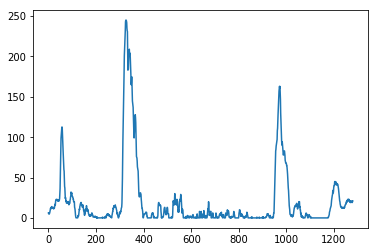

In [4]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Load our image
# `mpimg.imread` will load .jpg as 0-255, so normalize back to 0-1
img = mpimg.imread('warped-example.jpg')/255

def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    half_rows = img.shape[0] //2;
    bottom_half = img[half_rows:,:]
    
    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

# Create histogram of image binary activations
histogram = hist(img)

# Visualize the resulting histogram
plt.plot(histogram)

# Sliding Window

- With this histogram we are adding up the pixel values along each column in the image.
- In our thresholded binary image, pixels are either 0 or 1, 
 - so the two most prominent peaks in this histogram will be good indicators of the x-position of the base of the lane lines. 
 - Hence we can use that as a starting point for where to search for the lines. 
 - From that point, we can use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame.

- Here is a short animation showing this method:
[![sliding window](http://img.youtube.com/vi/siAMDK8C_x8/0.jpg)](https://youtu.be/siAMDK8C_x8 "sliding window")


# Implement Sliding Windows and Fit a Polynomial

!['mplement Sliding Windows and Fit a Polynomial'](sliding_window.png)

- Use the two highest peaks from  histogram as a starting point for determining where the lane lines are
    - then use sliding windows moving upward in the image (further along the road) to determine where the lane lines go
    


### Split the histogram for the two lines

- The first step we'll take is to split the histogram into two sides, one for each lane line.

```python
import numpy as np
import cv2
import matplotlib.pyplot as plt

halfRows = binary_warped.shape[0]//2
hist = np.sum(binary_wraped[halfRows:,:], axis=0) 

# Create an output image to draw on and visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Find the peak of the left and right halves of the histogram
midpoint = histogram.shape[0]//2
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

```

### Set up windows and window hyperparameters

- Set a few hyperparameters related to our sliding windows, 
    - and set them up to iterate across the binary activations in the image. 
- We have some base hyperparameters below, but don't forget to try out different values in your own implementation to see what works best!

```python
 
# Choose the number of sliding windows
nwindows = 9

# Set the width of the windows +/- margin
margin = 100

# Set minimum number of pixels found to recenter window
minpix = 50

# Set height of windows - based on nwindows above and image shape
window_height = np.int(binary_warped.shape[0]//nwindows)

# Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated later for each window in nwindows
leftx_current = leftx_base
rightx_current = rightx_base

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []
```

### Iterate through `nwindows` to track curvature

- Now that we've set up what the windows look like and have a starting point, we'll want to loop for nwindows,
    - with the given window sliding left or right if it finds the mean position of activated pixels within the window to have shifted.


1. Loop through each window in nwindows
2. Find the boundaries of our current window. 
     - This is based on a combination of the current window's starting point (leftx_current and rightx_current), 
         - as well as the margin you set in the hyperparameters.
         
3. Use cv2.rectangle to draw these window boundaries onto our visualization image out_img. 
    - This is required for the quiz. Can skip this step in practice if you don't need to visualize where the windows are.

4. Now that we know the boundaries of our window, find out which activated pixels from nonzeroy and nonzerox above actually fall into the window.

5. Append these to our lists left_lane_inds and right_lane_inds.

6. If the number of pixels found in Step 4 are greater than hyperparameter minpix, re-center our window 
    - (i.e. leftx_current or rightx_current) based on the mean position of these pixels.

### Fit a polynomial

Now that we have found all our pixels belonging to each line through the sliding window method, it's time to fit a polynomial to the line. First, we have a couple small steps to ready our pixels.

```python

# Concatenate the arrays of indices (previously was a list of lists of pixels)
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]

rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

```

We'll implement the function for the polynomial in the quiz below using np.polyfit.

```python

# Assuming we have `left_fit` and `right_fit` from `np.polyfit` before
# Generate x and y values for plotting

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
```

### Visualization

```python
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

plt.imshow(out_img)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

plt.xlim(0, 1280)
plt.ylim(720, 0)
```


left_fit [ 2.17600453e-04 -3.87364172e-01  4.78000379e+02]
right_fit [ 4.22146855e-04 -4.80877497e-01  1.11530271e+03]


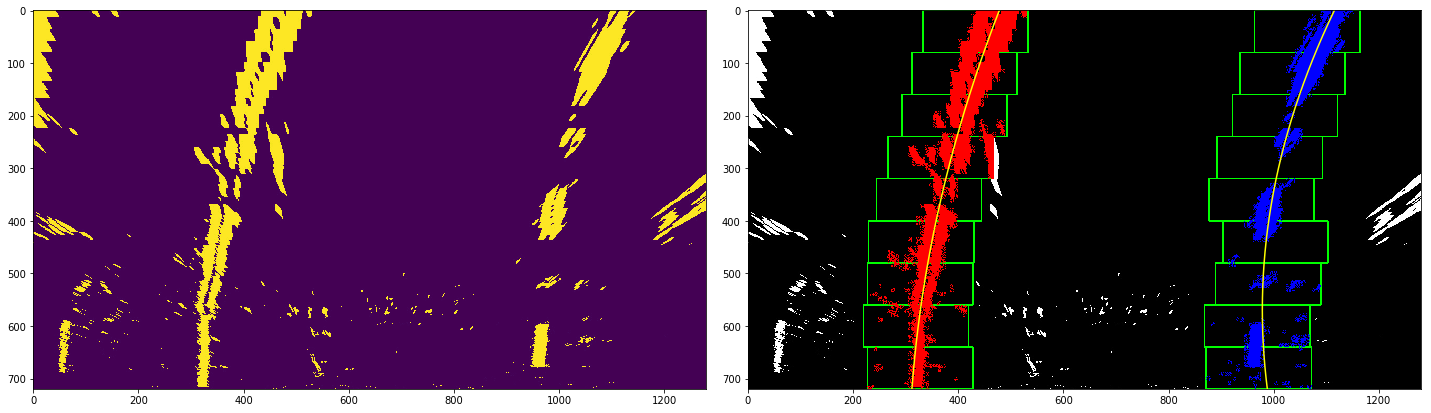

In [19]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

img = mpimg.imread('warped-example.jpg')

# img is an binary_warped image
def find_lane_lines(img):
    bottom_half = img.shape[0]//2
    hist = np.sum(img[bottom_half:,:], axis=0)
    out_img = np.dstack((img, img, img))
    
    # The peak of the left and right halves of the histogram
    midpoint = np.int(hist.shape[0]//2)
    leftx_base  = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint
    
    # HYPERPARAMETERS: number of sliding windows
    nwindows = 9
    
    # Width of the windows +/- margin
    margin = 100
    
    # Mimimum number of pixels found to re-center window
    minpix = 50
    
    window_height = np.int(img.shape[0]//nwindows)
    
    # x and y positions of all nonzero pixel in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base        
    for window in range(nwindows):
        
        # left and right window boundaries in x and y
        win_y_low  = img.shape[0]  - (window+1)*window_height
        win_y_high = img.shape[0]  -  window*window_height
        
        win_xleft_low  = leftx_current - margin
        win_xleft_high = leftx_current + margin
        
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img, (win_xleft_low,  win_y_low),
                               (win_xleft_high, win_y_high), (0,255,0), 2)
        
        cv2.rectangle(out_img, (win_xright_low,  win_y_low),
                               (win_xright_high, win_y_high), (0,255,0), 2)        
        
        good_left_inds = []
        good_right_inds = []
        
        ## TODO: No need to scan whole image here.
        for i in range(len(nonzeroy)):
            if nonzeroy[i] >= win_y_low and nonzeroy[i] <= win_y_high:
                if nonzerox[i] >= win_xleft_low  and nonzerox[i] <= win_xleft_high:
                    good_left_inds.append(i)                    
                if nonzerox[i] >= win_xright_low and nonzerox[i] <= win_xright_high:
                    good_right_inds.append(i)
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        if len(good_left_inds)  > minpix:
            leftx_current  = np.int(np.mean(nonzerox[good_left_inds])) 
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(img):
    leftx, lefty, rightx, righty, out_img = find_lane_lines(img)

    # Fit a second order polynomial 
    left_fit = np.polyfit(lefty, leftx, 2)    
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        print('I failed to fit a line!!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    # Color in left and right lane pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    print('left_fit', left_fit)
    print('right_fit', right_fit)

    return ploty, left_fitx, right_fitx, out_img


ploty, left_fitx, right_fitx, out_img = fit_polynomial(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 16))
f.tight_layout()

ax1.imshow(img)
ax2.imshow(out_img)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')

# Skip the sliding windows step once we've found the lines

Using the `fit_polynomial(img)` pipleline and starting fresh on every frame as shown above is inefficient, 
as the lane lines don't necessarily move a lot from frame to frame.

In the next frame of video we don't need to do a blind search again, but instead we can just search in a margin around the previous lane line position, like in the above image. 

The green shaded area shows where we searched for the lines this time. 
So, once we know where the lines are in one frame of video, we can do a highly targeted search for them in the next frame.

!['slide-window-video.png'](slide-window-video.png)



- This is equivalent to using a customized region of interest for each frame of video, 
    - and help us track the lanes through sharp curves and tricky conditions. 
    
- If we lose track of the lines, go back to sliding windows search or other method to rediscover them.
- Let us walk through one way to do this, and then we will build it out further in a quiz below.

###  Use the previous polynomial to skip the sliding window

Previously, we used `left_lane_inds` and `right_lane_inds` to hold the pixel values contained within the boundaries of a given sliding window. 

This time, we'll take the polynomial functions we fit before (`left_fit` and `right_fit`), along with a hyperparameter `margin`, to determine which activated pixels fall into the green shaded areas from the above image. 

*Note that this margin can be a different value than the one originally used for your sliding windows!*

To implement this in the below quiz, you'll want to grab only those pixels with x-values that are +/- your margin from your polynomial lines. 

Note that you'll only need to implement `left_lane_inds` and `right_lane_inds` in the quiz - most of the surrounding code, ignoring iterating through the windows, is the same as before!

The way we'll visualize this is a bit different than last time around, however, so make sure to pay attention to that if you want to visualize this step while working on your project.

### Quiz
- Fit a polynomial to all the relevant pixels you've found in your sliding windows in fit_poly().
- Set the area to search for activated pixels based on margin out from your fit polynomial within search_around_poly. 
  - Note that the quiz grader expects a margin of 100 pixels, but you can tune this as part of your own project!
  
 

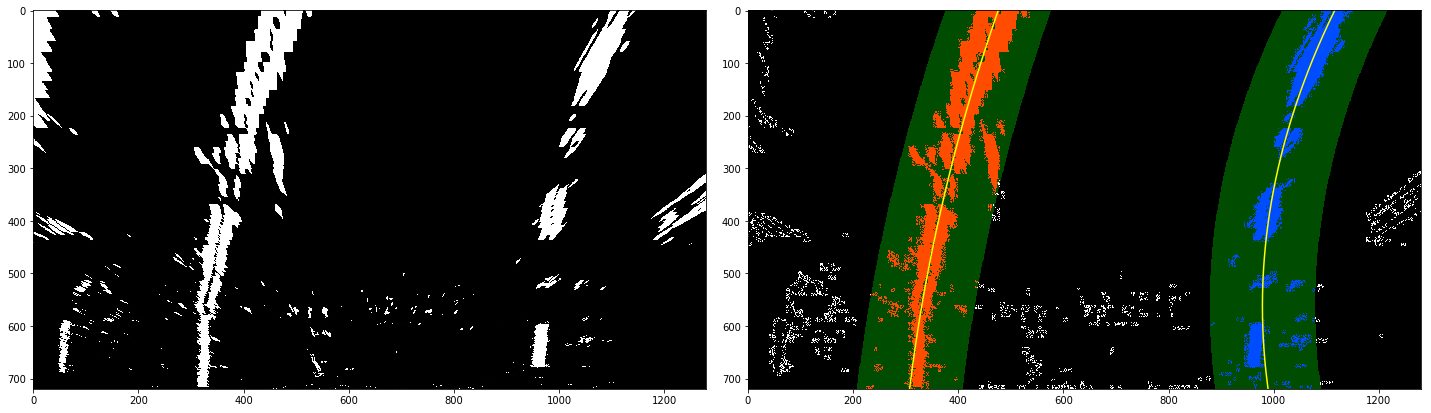

In [5]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

binary_warped = mpimg.imread('warped-example.jpg')

left_fit  = np.array([ 2.17600453e-04, -3.87364172e-01,  4.78000379e+02])
right_fit = np.array([ 4.22146855e-04, -4.80877497e-01,  1.11530271e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    left_fit  = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])    
    left_fitx =  left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

# HYPERPARAMETER
# Choose the width of the margin around the previous polynomial to search
# The quiz grader expects 100 here, but feel free to tune on your own!
def search_around_poly(binary_warped, margin = 100):

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###    
    left_lane_inds = (  (nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) &
                        (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))
                     )
    
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin))
                      )
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    # plt.plot(left_fitx, ploty, color='yellow')
    # plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return ploty, left_fitx, right_fitx, result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
ploty, left_fitx, right_fitx, result = search_around_poly(binary_warped)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 16))
f.tight_layout()

ax1.imshow(binary_warped, cmap='gray')
ax2.imshow(result)
ax2.plot(left_fitx,  ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')



# Measuring Curvature

- We have a thresholded image, where estimated pixels belong to the left and right lane lines 
   - (shown in red and blue, respectively, below)
- we've fit a polynomial to those pixel positions. 

Now we'll compute the radius of curvature of the fit.

!['Here I have fit the left and right lines with a second order polynomial shown in green.'](color-fit-lines.jpg)


we located the lane line pixels, used x and y pixel positions to fit a second order polynomial curve:

$f(y) = Ay^2 + By + C$


- We're fitting for f(y), rather than f(x), because the lane lines in the warped image are near vertical 
   - and may have the same x value for more than one y value.

### Radius of Curvature

- The radius of curvature, [tutorial here](https://www.intmath.com/applications-differentiation/8-radius-curvature.php), at any point x of the function $x = f(y)$ is given as follows:


$\huge{R_{curve} = \frac{[1+(\frac{dx}{dy})^2]^{3/2}}{|\frac{d^2x}{dy^2}|}} $

$\large f^{'}(y) = \frac{dx}{dy} = 2Ay + B $

$\large f^{''}(y) = \frac{d^2x}{dy^2} = 2A $

So, equation for radius of curvature becomes:

$\huge{R_{curve} = \frac{(1+(2Ay+B)^2)^{3/2}}{|2A|}} $


The $y$ values of image increase from top to bottom, so if, for example, we wanted to measure the radius of curvature closest to your vehicle, you could evaluate the formula above at the $y$ value corresponding to the bottom of the image, or in Python, at $yvalue = image.shape[0]$


# Implementing the Calculation


### Generate some fake data first



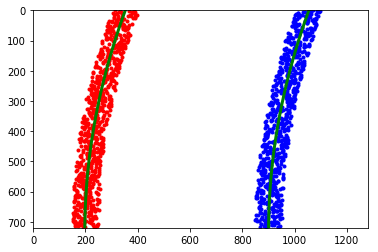

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image

quadratic_coeff = 3e-4 # arbitrary quadratic coefficient

# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)

leftx  = np.array([200 + quadratic_coeff*(y**2) + np.random.randint(-50, high=51) for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]

right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)

plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [8]:
import numpy as np

def generate_data():
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image    
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx  = np.array([200 + quadratic_coeff*(y**2) + np.random.randint(-50, high=51) for y in ploty])
    rightx = np.array([900 + quadratic_coeff*(y**2) + np.random.randint(-50, high=51) for y in ploty])

    leftx  = leftx[::-1]   # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit  = np.polyfit(ploty, leftx, 2)
    right_fit = np.polyfit(ploty, rightx, 2)
    
    return ploty, left_fit, right_fit

    
def measure_curvature_pixels():
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit, right_fit = generate_data()
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### Compute R_curve (radius of curvature) #####
    ##### R_curve = (1 + (2Ay+B)^2)^3/2  / |2A| #####
    left_curverad =  (1 + (2*left_fit[0] * y_eval + left_fit[1])**2)**(3/2)  / np.abs(2*left_fit[0])
    right_curverad = (1 + (2*right_fit[0]* y_eval + right_fit[1])**2)**(3/2) / np.abs(2*right_fit[0])
    
    return left_curverad, right_curverad

# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels()

print(left_curverad, right_curverad)
# Should see values of 1625.06 and 1976.30 here, if using
# the default `generate_data` function with given seed number    

1625.0601831657204 1976.2967307714334


# From Pixels to Real-World

- We've calculated the radius of curvature for our lane lines. 
- But now we need to stop and think... 
- We've calculated the radius of curvature based on pixel values, so the radius we are reporting is in pixel space, 
  - which is not the same as real world space. 
    
So we actually need to repeat this calculation after converting our x and y values to real world space.

- This involves measuring how long and wide the section of lane is that we're projecting in our warped image. 
- We could do this in detail by measuring out the physical lane in the field of view of the camera, 
    - but for this project, you can assume that if you're projecting a section of lane similar to the images above,
    - the lane is about 30 meters long and 3.7 meters wide. 
    
- Or, if you prefer to derive a conversion from pixel space to world space in your own images, 
   - compare your images with U.S. regulations that require a minimum lane width of 12 feet or 3.7 meters, 
   - and the dashed lane lines are 10 feet or 3 meters long each.

- Let's say that our camera image has 720 relevant pixels in the y-dimension 
    - (remember, our image is perspective-transformed!), 
    - and we'll say roughly 700 relevant pixels in the x-dimension 
    - (our example of fake generated data above used from 200 pixels on the left to 900 on the right, or 700).
    - Therefore, to convert from pixels to real-world meter measurements, we can use:
    
    ```python
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ```

- In the below code, we'll use the above conversions in order to adjust calculation from before to give real-world lane curvature values. 

- we'll focus on the left_curverad and right_curverad values within the new measure_curvature_real() function; 
- however, we'll also need to adjust how you use $np.polyfit()$ within `generate_data()` in order for this to work correctly. 

- How do you need to change these to convert to meters?

In [1]:
import numpy as np

def generate_data(ym_per_pix, xm_per_pix):
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    np.random.seed(0)
    
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    
    leftx  = np.array([200 + quadratic_coeff*(y**2) + np.random.randint(-50, high=51) for y in ploty])
    rightx = np.array([900 + quadratic_coeff*(y**2) + np.random.randint(-50, high=51) for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  

    # Fit a second order polynomial to pixel positions in each fake lane line
    # Fit new polynomials to x,y in world space
    left_fit_coef  = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2) 
    right_fit_coef = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return ploty, left_fit_coef, right_fit_coef
    
def measure_curvature_real():
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit_coef, right_fit_coef = generate_data(ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)*ym_per_pix
    
    # Compute R_curve (radius of curvature)
    left_curveR =  ((1 + (2*left_fit_coef[0] *y_eval + left_fit_coef[1])**2)**1.5)  / np.absolute(2*left_fit_coef[0])
    right_curveR = ((1 + (2*right_fit_coef[0]*y_eval + right_fit_coef[1])**2)**1.5) / np.absolute(2*right_fit_coef[0])
    
    return left_curveR, right_curveR


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real()

print(left_curverad, 'm', right_curverad, 'm')
# Should see values of 533.75 and 648.16 here, if using
# the default `generate_data` function with given seed number

533.7525889210938 m 648.157485143441 m


### An alternative approach which may scale more efficiently. 

- once the parabola coefficients are obtained, in pixels, convert them into meters. 
- For example, if the parabola is $x= a*(y**2) +b*y+c;$ 
  - and mx and my are the scale for the x and y axis, respectively (in meters/pixel); 
  - then the scaled parabola is $ x= mx / (my ** 2) *a*(y**2)+(mx/my)*b*y+c $
  

- Check out U.S. [government specifications](http://onlinemanuals.txdot.gov/txdotmanuals/rdw/horizontal_alignment.htm#BGBHGEGC)  for highway curvature to see how your numbers compare. 
    - There's no need to worry about absolute accuracy in this case, but your results should be "order of magnitude" correct.
  